# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random

from extrucal.extrusion import throughput_cal

from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
import warnings

from sklearn.utils import shuffle

from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchsummary import summary
from torchmetrics import MeanAbsolutePercentageError
random.seed(0)

# Dataset Read In

In [2]:
df = pd.read_csv("../data/extrucal_dataset.csv")
df

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput
0,80,7.2,1200,95,48.0,12.0,2,92.55
1,220,17.6,1300,75,154.0,13.2,1,4397.68
2,190,7.6,1400,95,323.0,36.1,2,3187.76
3,190,7.6,800,55,228.0,26.6,1,1008.12
4,60,1.8,800,10,48.0,10.8,1,2.72
...,...,...,...,...,...,...,...,...
1935355,40,3.2,1000,30,32.0,4.0,1,8.78
1935356,180,3.6,800,85,306.0,27.0,2,762.58
1935357,30,1.8,1100,60,30.0,2.7,1,7.89
1935358,70,6.3,1000,40,35.0,10.5,2,11.59


# Useful Functions

In [3]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [4]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / (true+0.1)))  # 0.1 was added to prevent division by zero

# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

# Train/Test Split

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df.head()

,extruder_size,metering_depth,polymer_density,rpm,screw_pitch,flight_width,number_flight,throughput
665324,120,9.6,1400,50,72.0,24.0,2,93.53
775241,230,9.2,1200,45,161.0,43.7,2,624.11
867365,220,11.0,800,90,242.0,13.2,1,3208.52
1458314,250,10.0,1150,0,300.0,50.0,2,0.00
1097383,70,5.6,800,45,77.0,7.0,2,64.95


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1548288 entries, 665324 to 773630
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   extruder_size    1548288 non-null  int64  
 1   metering_depth   1548288 non-null  float64
 2   polymer_density  1548288 non-null  int64  
 3   rpm              1548288 non-null  int64  
 4   screw_pitch      1548288 non-null  float64
 5   flight_width     1548288 non-null  float64
 6   number_flight    1548288 non-null  int64  
 7   throughput       1548288 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 106.3 MB


In [7]:
X_train = train_df.drop(columns=["throughput"])
y_train = train_df["throughput"]

X_test = test_df.drop(columns=["throughput"])
y_test = test_df["throughput"]

In [8]:
X_train_t = X_train.iloc[:774144, :]
y_train_t = y_train[:774144]

X_train_v = X_train.iloc[774144:, :]
y_train_v = y_train[774144:]

# `Neural Network`

### 1. Model Setup

In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 24),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(24, 12),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(12, 6),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(6, output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
def prepare_dataloader(X_train, y_train, batch_size, shuffle=True):
    # generate sequences
    scaler = StandardScaler()  # standardize data
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_y_train = scaler.fit_transform(y_train[:, np.newaxis])
    dataset = TensorDataset(torch.tensor(scaled_X_train, dtype=torch.float32).unsqueeze(-1).permute(0, 2, 1),
                            torch.tensor(scaled_y_train, dtype=torch.float32))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return dataloader, scaled_X_train, scaled_y_train, scaler

In [11]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, train_MAPE, valid_MAPE = [], [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        train_batch_mape = 0
        valid_batch_mape = 0
        
        # Training
        for X, y in trainloader:
            optimizer.zero_grad()       # Zero all the gradients w.r.t. parameters
            # X = X.to(device)
            # y = y.to(device)
            y_hat = model(X.reshape(X.shape[0], -1))  # Reshape data 
            loss = criterion(y_hat, y)  # Calculate loss based on output
            loss.backward()             # Calculate gradients w.r.t. parameters
            optimizer.step()            # Update parameters
            train_batch_loss += loss.item()  # Add loss for this batch to running total
            train_batch_mape += mape(y.detach().numpy(), y_hat.detach().numpy()).mean()
        train_loss.append(train_batch_loss/len(trainloader))
        train_MAPE.append(train_batch_mape/len(trainloader))  # MAE
        
        # Validation
        model.eval()
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in validloader:
                # X = X.to(device)
                # y = y.to(device)
                y_hat = model(X.reshape(X.shape[0], -1))  # Reshape data to (batch_size, 784) and forward pass to get output
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_mape += mape(y.detach().numpy(), y_hat.detach().numpy()).mean()
        valid_loss.append(valid_batch_loss/len(validloader))
        valid_MAPE.append(valid_batch_mape/len(validloader))  # accuracy
        
        model.train()
        
        # Print progress
        if verbose:
            if epoch % 10 == 0:
                print(f"Epoch {epoch}:",
                      f"Train Loss: {train_loss[-1]:.3f}.",
                      f"Valid Loss: {valid_loss[-1]:.3f}.",
                      f"Train MAPE: {train_MAPE[-1]:.2f}."
                      f"Valid MAPE: {valid_MAPE[-1]:.2f}.")
            
    print("\nTraining ended.")
    
    return train_loss, valid_loss

In [12]:
torch.manual_seed(42)

model = NeuralNetwork(7, 1)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = MeanAbsolutePercentageError()
BATCH_SIZE = 32

In [13]:
summary(model, (1, 7), device="cpu");

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 7]                   --
├─Sequential: 1-2                        [-1, 1]                   --
|    └─Linear: 2-1                       [-1, 24]                  192
|    └─ReLU: 2-2                         [-1, 24]                  --
|    └─Linear: 2-3                       [-1, 12]                  300
|    └─ReLU: 2-4                         [-1, 12]                  --
|    └─Linear: 2-5                       [-1, 6]                   78
|    └─ReLU: 2-6                         [-1, 6]                   --
|    └─Linear: 2-7                       [-1, 1]                   7
Total params: 577
Trainable params: 577
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


### 1. Training

In [14]:
trainloader, scaled_X_train_t, scaled_y_train_t, scaler = prepare_dataloader(
    X_train_t, y_train_t, batch_size=BATCH_SIZE, shuffle=True
)
validloader, scaled_X_train_v, scaled_y_train_v, scaler = prepare_dataloader(
    X_train_v, y_train_v, batch_size=BATCH_SIZE, shuffle=True
)

C:\Users\johnw\AppData\Local\Temp\ipykernel_5220\4062483606.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scaled_y_train = scaler.fit_transform(y_train[:, np.newaxis])
C:\Users\johnw\AppData\Local\Temp\ipykernel_5220\4062483606.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scaled_y_train = scaler.fit_transform(y_train[:, np.newaxis])


In [15]:
%%time

train_loss, valid_loss = trainer(
    model, criterion, optimizer, trainloader, validloader, epochs=101, verbose=True
)

Epoch 0: Train Loss: 0.446. Valid Loss: 0.502. Train MAPE: 284.03.Valid MAPE: 103.69.
Epoch 10: Train Loss: 0.176. Valid Loss: 0.177. Train MAPE: 130.18.Valid MAPE: 35.27.
Epoch 20: Train Loss: 0.279. Valid Loss: 0.156. Train MAPE: 182.24.Valid MAPE: 30.75.
Epoch 30: Train Loss: 0.194. Valid Loss: 0.166. Train MAPE: 121.09.Valid MAPE: 28.94.
Epoch 40: Train Loss: 0.160. Valid Loss: 0.132. Train MAPE: 68.13.Valid MAPE: 24.09.
Epoch 50: Train Loss: 0.183. Valid Loss: 0.086. Train MAPE: 102.12.Valid MAPE: 25.52.
Epoch 60: Train Loss: 0.198. Valid Loss: 0.126. Train MAPE: 91.28.Valid MAPE: 30.33.
Epoch 70: Train Loss: 0.158. Valid Loss: 0.106. Train MAPE: 87.96.Valid MAPE: 31.93.
Epoch 80: Train Loss: 0.165. Valid Loss: 0.122. Train MAPE: 115.89.Valid MAPE: 31.34.
Epoch 90: Train Loss: 0.160. Valid Loss: 0.119. Train MAPE: 38.90.Valid MAPE: 21.23.
Epoch 100: Train Loss: 0.143. Valid Loss: 0.161. Train MAPE: 68.99.Valid MAPE: 25.51.

Training ended.
CPU times: total: 1h 21min 48s
Wall time:

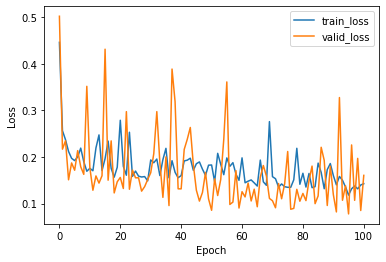

In [16]:
loss_dict = {"train_loss": train_loss, "valid_loss": valid_loss}
loss_df = pd.DataFrame(loss_dict)
loss_df.plot.line()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show();

In [17]:
torch.save(model.state_dict(), 'nn_model_weights.pth')

### 2. Evaluation

In [18]:
testloader, scaled_X_test, scaled_y_test, scaler = prepare_dataloader(
    X_test, y_test, batch_size=1, shuffle=False
)

C:\Users\johnw\AppData\Local\Temp\ipykernel_5220\4062483606.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scaled_y_train = scaler.fit_transform(y_train[:, np.newaxis])


In [19]:
scaled_prediction = []

for X, _ in testloader:
    y_pred = model(X.reshape(X.shape[0], -1))
    scaled_prediction.append(y_pred.item())

In [20]:
y_pred = scaler.inverse_transform(np.array(scaled_prediction).reshape(-1, 1)).squeeze()

In [21]:
mape(y_test, y_pred)

3993.7607298882995

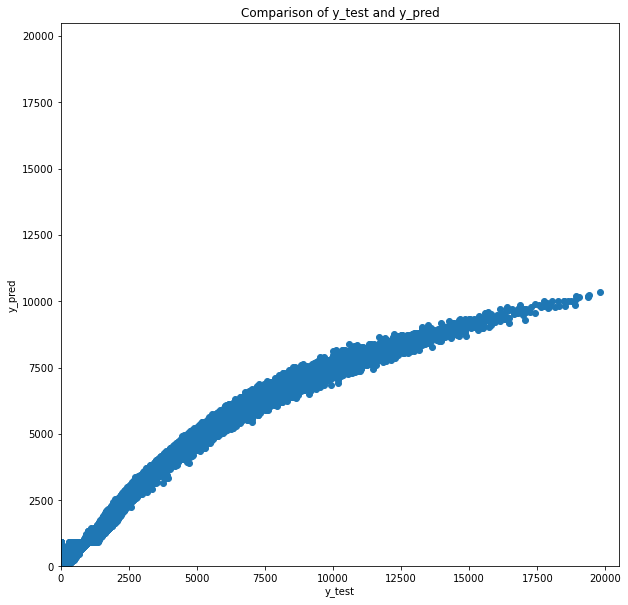

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.xlim(0, 20500)
plt.ylim(0, 20500)
plt.title("Comparison of y_test and y_pred")
plt.show();

### 3. Comparison with `extrucal` results

In [23]:
# extruder_size = []
# for i in range(50, 251, 50):
#     extruder_size.extend([i]*10)

# metering_depth_percent = [0.05] * 50
# polymer_density = [1000] * 50
# screw_pitch_percent = [1] * 50
# flight_width_percent = [0.1] * 50
# number_flight = [1] * 50
# rpm = [r for r in range(0, 91, 10)] * 5

In [24]:
# df = pd.DataFrame(
#     {"extruder_size": extruder_size,
#      "metering_depth_percent": metering_depth_percent,
#      "polymer_density": polymer_density,
#      "screw_pitch_percent": screw_pitch_percent,
#      "flight_width_percent": flight_width_percent,
#      "number_flight": number_flight,
#      "rpm": rpm}
# )

# df["metering_depth"] = df["extruder_size"] * df["metering_depth_percent"]
# df["screw_pitch"] = df["extruder_size"] * df["screw_pitch_percent"]
# df["flight_width"] = df["extruder_size"] * df["flight_width_percent"]

# new_col_order = [
#     "extruder_size", "metering_depth", "polymer_density", 
#     "rpm", "screw_pitch", "flight_width", "number_flight", ]

# df = df[new_col_order]
# df.head()

In [25]:
# df["RF_model"] = model(torch.tensor(np.array(df.iloc[0])))

In [26]:
# df["extrucal"] = df.apply(
#     lambda row: throughput_cal(
#         row["extruder_size"],
#         row["metering_depth"],
#         row["polymer_density"],
#         row["rpm"],
#         row["screw_pitch"],
#         row["flight_width"],
#         int(row["number_flight"])), axis=1
# )

In [27]:
# fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 20))

# fig = df.loc[0:9, ["rpm", "extrucal", "RF_model"]].plot.line(
#     x="rpm", ax=axes[0], alpha=0.5
# )
# fig.set_title("50mm Extruder", loc='left')
# fig = df.loc[10:19, ["rpm", "extrucal", "RF_model"]].plot.line(
#     x="rpm", ax=axes[1], alpha=0.5
# )
# fig.set_title("100mm Extruder", loc='left')
# fig = df.loc[20:29, ["rpm", "extrucal", "RF_model"]].plot.line(
#     x="rpm", ax=axes[2], alpha=0.5
# )
# fig.set_title("150mm Extruder", loc='left')
# fig = df.loc[30:39, ["rpm", "extrucal", "RF_model"]].plot.line(
#     x="rpm", ax=axes[3], alpha=0.5
# )
# fig.set_title("200mm Extruder", loc='left')
# fig = df.loc[40:, ["rpm", "extrucal", "RF_model"]].plot.line(
#     x="rpm", ax=axes[4], alpha=0.5
# )
# fig.set_title("250mm Extruder", loc='left')
# plt.show();